In [66]:
from sympy import *
from sympy.physics.mechanics import * 
import numpy as np
from scipy.integrate import odeint, ode, solve_ivp


init_vprinting()

In [102]:
y = symbols('x y')
b, m, M, g, ell, t = symbols('b m M g ell t')
theta, x1 = dynamicsymbols('theta x1')

x2 = x1 + ell*sin(theta)
y2 = -ell*cos(theta)

x2_dot = diff(x2, t)
y2_dot = diff(y2, t)

theta_dot = diff(theta, t)
theta_ddot = diff(theta_dot, t)

x1_dot = diff(x1, t)
x1_ddot = diff(x1_dot, t)




#Lagrangian
T  = 1/2 * m * (x2_dot**2 + y2_dot**2) + 1/2 * M * x1_dot**2
V = m*g*y2
L = T - V
L = simplify(L)
#Euler-lagrange
eqn1 = diff(diff(L, theta_dot), t) - diff(L, theta) 
eqn2 = diff(diff(L, x1_dot), t) - diff(L, x1)

sln1 = solve(eqn1, theta_ddot)[0]
sln2 = solve(eqn2, x1_ddot)[0]
eqn2

# Eq(theta_ddot, sln1))



In [72]:
# x = Matrix([theta, theta_dot])
# x_dot = diff(x, t)
x_vec = Matrix([x1, x1_dot, theta, theta_dot])
x_vec_dot = diff(x_vec, t)

Eq(x_vec_dot, Matrix([x1_dot, sln2, theta_dot, sln1]))

       ⎡             x₁̇             ⎤
       ⎢                            ⎥
       ⎢      ⎛        2           ⎞⎥
⎡x₁̇⎤   ⎢ell⋅m⋅⎝sin(θ)⋅θ̇  - cos(θ)⋅θ̈⎠⎥
⎢  ⎥   ⎢────────────────────────────⎥
⎢x₁̈⎥   ⎢           M + m            ⎥
⎢  ⎥ = ⎢                            ⎥
⎢θ̇ ⎥   ⎢             θ̇              ⎥
⎢  ⎥   ⎢                            ⎥
⎣θ̈ ⎦   ⎢  -(g⋅sin(θ) + cos(θ)⋅x₁̈)   ⎥
       ⎢  ────────────────────────  ⎥
       ⎣            ell             ⎦

Forsiktig med rekkefølgen på likningene


In [73]:
equation1_corrected = (ell*m*sin(theta)*theta_dot**2)/(M+m)
equation2_corrected = -(g*sin(theta))/ell

In [74]:
correction_matrix = Matrix([[1,0,0,0],
                            [0,1,0,cos(theta)/(M+m)],
                            [0,0,1,0],
                            [0,+cos(theta)/ell,0,1]])
correction_matrix

⎡1    0     0    0   ⎤
⎢                    ⎥
⎢              cos(θ)⎥
⎢0    1     0  ──────⎥
⎢              M + m ⎥
⎢                    ⎥
⎢0    0     1    0   ⎥
⎢                    ⎥
⎢   cos(θ)           ⎥
⎢0  ──────  0    1   ⎥
⎣    ell             ⎦

In [75]:
correction_matrix_inv = correction_matrix.inv()
correction_matrix_inv

⎡1             0             0             0           ⎤
⎢                                                      ⎥
⎢        M⋅ell + ell⋅m                -ell⋅cos(θ)      ⎥
⎢0  ───────────────────────  0  ───────────────────────⎥
⎢                      2                           2   ⎥
⎢   M⋅ell + ell⋅m - cos (θ)     M⋅ell + ell⋅m - cos (θ)⎥
⎢                                                      ⎥
⎢0             0             1             0           ⎥
⎢                                                      ⎥
⎢     -M⋅cos(θ) - m⋅cos(θ)           M⋅ell + ell⋅m     ⎥
⎢0  ───────────────────────  0  ───────────────────────⎥
⎢                      2                           2   ⎥
⎣   M⋅ell + ell⋅m - cos (θ)     M⋅ell + ell⋅m - cos (θ)⎦

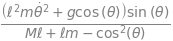

In [103]:
A = Matrix([x1_dot, equation1_corrected, theta_dot, equation2_corrected])
ODE_equations = simplify(correction_matrix_inv*A)
ODE_equations[1]

In [104]:
f1 = lambdify((m, M, g, ell,theta, theta_dot), ODE_equations[1])
f2 = lambdify((m, M, g, ell,theta, theta_dot), ODE_equations[3])
f2

<function _lambdifygenerated(m, M, g, ell, _Dummy_598, _Dummy_597)>

In [105]:
g = 9.81
M = 5
m = 2
ell = 2


def ODE(t, y):
   x1 = y[0]
   x1_dot = y[1]
   theta = y[2]
   theta_dot = y[3] 

   x1_dd = f1(m, M, g, ell,theta, theta_dot)
   theta_dd = f2(m, M, g, ell,theta, theta_dot)

   return (x1_dot, x1_dd, theta_dot, theta_dd)

In [125]:

x0 = 0
x_dot0 = 0
theta0 = np.deg2rad(90)
theta_dot0 = 0

steps = 30
t = 10
frames = np.linspace(0,t, steps*t)


sol = solve_ivp(ODE, [0, t], [x0, x_dot0, theta0, theta_dot0], t_eval=frames)


x = sol.y[0]
x_dot = sol.y[1]
theta = sol.y[2]
theta_dot = sol.y[3]
t = sol.t

theta_deg = np.rad2deg(sol.y[2])
theta_dot_deg = np.rad2deg(sol.y[3])

np.savetxt('pend_new.csv', np.transpose([theta_deg, theta_dot_deg]), delimiter=',')



In [136]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

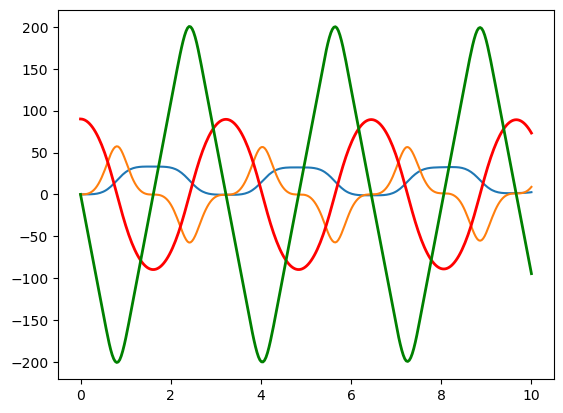

In [128]:
plt.plot(t, 40*x)
plt.plot(t, 40*x_dot)
plt.plot(t, theta_deg, lw=2, color='r')
plt.plot(t, theta_dot_deg, lw = 2, color = 'g')
plt.show()

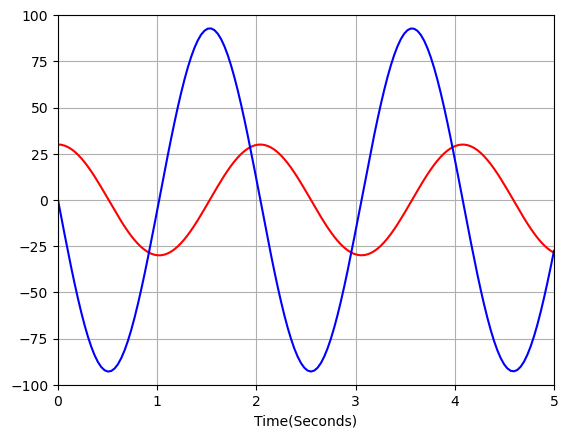

In [94]:
fig, ax = plt.subplots()

theta_curve, = ax.plot(t[0], theta_deg[0], 'r')
theta_dot_curve, = ax.plot(t[0], theta_dot_deg[0], 'b')
ax.grid()

ax.set_xlabel('Time(Seconds)')


ax.set_xlim(0,5)
ax.set_ylim(-100,100)


def animate(i):
   theta_curve.set_data(t[:i+1], theta_deg[:i+1])
   theta_dot_curve.set_data(t[:i+1], theta_dot_deg[:i+1])

ani = animation.FuncAnimation(fig, animate, frames=len(t))
ffmpeg_writer = animation.FFMpegWriter(fps=30)
ani.save('time_domain.mp4', writer=ffmpeg_writer)


In [142]:
y0

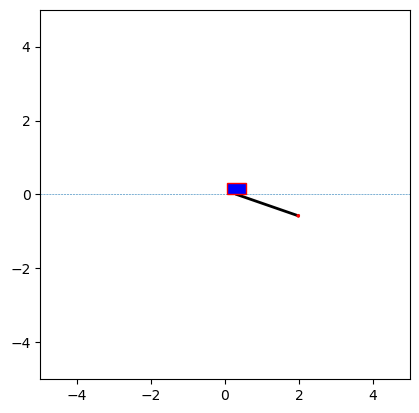

In [158]:
def pend_pos(x, theta):
   return (x + ell*np.sin(theta), -ell*np.cos(theta))




fig = plt.figure()
ax2 = fig.add_subplot(aspect='equal')
ax2.axhline(y=0, linewidth = 0.4, linestyle='dashed')




# ax0 = fig.add_subplot(gs[0,0])
# ax1 = fig.add_subplot(gs[1,0])
# ax2 = fig.add_subplot(gs[:,1])

# theta_curve, = ax0.plot(t[0], theta_deg[0], 'r')
# theta_dot_curve, = ax0.plot(t[0], theta_dot_deg[0], 'b')

# phase_curve, = ax1.plot(theta_deg[0], theta_dot_deg[0], 'b')
# phase_dot, = ax1.plot(theta_deg[0], theta_dot_deg[0], 'ro')

x0, y0 = pend_pos(x[0], theta0)

line, = ax2.plot([x[0], x0], [0, y0], lw=2, c = 'k')
circle =ax2.add_patch(plt.Circle(pend_pos(x[0], theta0), 0.05, fc='r', zorder=3))
# box = ax2.add_patch(plt.Rectangle([x[0], 0], 3, 2, fc='r'))
box = ax2.add_patch(patches.Rectangle((x[0], 0), 0.5, 0.3, linewidth=1, edgecolor='r', facecolor='b', zorder=3))


# ax0.set_xlim(0,5)
# ax0.set_ylim(-100,100)

# ax1.set_xlim(-40, 40)
# ax1.set_ylim(-100,100)
# ax1.grid()
# ax0.grid()

ax2.set_xlim(-5,5)
ax2.set_ylim(-5,5)



def animate(i):
   # theta_curve.set_data(t[:i+1], theta_deg[:i+1])
   # theta_dot_curve.set_data(t[:i+1], theta_dot_deg[:i+1])

   # phase_curve.set_data(theta_deg[:i+1], theta_dot_deg[:i+1])
   # phase_dot.set_data(theta_deg[i], theta_dot_deg[i])

   
   x2, y2 = pend_pos(x[i], theta[i])
   line.set_data([x[i]+ 0.25, x2], [0,y2])
   circle.set_center((x2,y2))
   # box.set_x([x[i], 0])
   box.set_x(x[i])


ani = animation.FuncAnimation(fig, animate, frames=len(t))
ffmpeg_writer = animation.FFMpegWriter(fps=30)
ani.save('time_domain_box.mp4', writer=ffmpeg_writer)









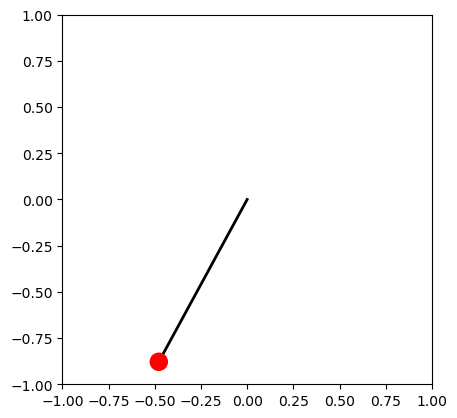

In [115]:
def pend_pos(theta):
   return (ell*np.sin(theta), -ell*np.cos(theta))

fig = plt.figure()
ax = fig.add_subplot(aspect='equal')


x0, y0 = pend_pos(theta0)
line, = ax.plot([0, x0], [0, y0], lw=2, c = 'k')
circle =ax.add_patch(plt.Circle(pend_pos(theta0), 0.05, fc='r', zorder=3))

ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)

def animate(i):
   x, y = pend_pos(theta[i])
   line.set_data([0, x], [0,y])
   circle.set_center((x,y))


ani = animation.FuncAnimation(fig, animate, frames=len(t))
ffmpeg_writer = animation.FFMpegWriter(fps=30)
ani.save('time_domain.mp4', writer=ffmpeg_writer)


